<img src= "img/pipelines.png" style="height:450px">


[Image Source](https://towardsdatascience.com/using-functiontransformer-and-pipeline-in-sklearn-to-predict-chardonnay-ratings-9b13fdd6c6fd)

__Agenda__

- Pipelines and Composite estimators

- Why do we need them?

- How to use them in sklearn: accessing a particular object in pipe and changing parameters

- ROC Curve

- Area under ROC Curve

In [1]:
import pandas as pd
import numpy as np

# Pipelines

__What is a Pipeline?__

_Transformers:_ Any object with .transform method. Ex: StandardScaler, OneHotEncoder.

_Estimators:_ Any object with predict method. Ex: RandomForestClassifier, LinearRegression etc.

_Pipelines:_ A tool for combining transformers with estimators. 


__Why do we need pipelines?__

- Convenience and encapsulation

Even though we train 10 transformers and 5 estimators we will call fit and predict once.

- Joint parameter selection - here emphasize preprocessing part

We can put pipelines into gridsearch and find best parameters for all the estimators at once.

- Safety

Pipelines help avoid leaking statistics from your test data into trained model.

[Pipelines and Composite Estimators](https://scikit-learn.org/stable/modules/compose.html#combining-estimators)



## Usage of Pipelines

The Pipeline is built using a list of (key, value) pairs, where the key is a string containing the name you want to give this step and value is an estimator object:

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

estimators = [('imputer', SimpleImputer()),
              ('scaler', StandardScaler()),
              ('clf', LogisticRegression(penalty='l1'))]

pipe = Pipeline(estimators)

pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf', LogisticRegression(penalty='l1'))])

__Your Turn__

- Create your own pipeline. You can use the same transformers and estimators with different parameters and 'name'.

- You can create a new pipe with a scaler also.

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

In [6]:
from sklearn.tree import DecisionTreeClassifier
your_estimators = [('knnimputer', KNNImputer()),
                   ('scaler', MinMaxScaler((0, 100))),
                   ('clf', DecisionTreeClassifier(max_depth=3))]
your_pipe = Pipeline(your_estimators)
your_pipe

Pipeline(steps=[('knnimputer', KNNImputer()),
                ('scaler', MinMaxScaler(feature_range=(0, 100))),
                ('clf', DecisionTreeClassifier(max_depth=3))])

Sklearn also gives us "make_pipeline" which is almost the same thing but with make_pipeline you don't have to give names.

__Your Turn__

-  [Check documentation: 6.1.1.1.1 Construction](https://scikit-learn.org/stable/modules/compose.html) and use `make_pipeline` to construct a pipeline.

In [7]:
from sklearn.pipeline import make_pipeline

In [8]:
your_make_pipe = make_pipeline(KNNImputer(), MinMaxScaler(feature_range=(0, 100)),
                               DecisionTreeClassifier(max_depth=3))
your_make_pipe

Pipeline(steps=[('knnimputer', KNNImputer()),
                ('minmaxscaler', MinMaxScaler(feature_range=(0, 100))),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=3))])

In [9]:
pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf', LogisticRegression(penalty='l1'))])

## Accessing steps

We have multiple ways to access and object in the pipeline

In [14]:
## note that these will all give the simple imputer object
# pipe[0]

# pipe['imputer']

pipe.steps[0][1]

SimpleImputer()

In [18]:
## We can also access a particular object by named_steps

pipe.named_steps.imputer

SimpleImputer()

In [19]:
## We can 'slice' pipelines to create sub-pipes

pipe[1:]

Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(penalty='l1'))])

## Access to the parameters

Parameters of the estimators in the pipeline can be accessed using the 
"estimator__parameter" syntax.

In [28]:
pipe.named_steps.scaler

StandardScaler(with_std=False)

In [29]:
_.get_params()

{'copy': True, 'with_mean': True, 'with_std': False}

In [22]:
pipe.set_params(clf__C = 10)

pipe

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('clf', LogisticRegression(C=10, penalty='l1'))])

In [27]:
pipe.set_params(scaler__with_std=False)
pipe

Pipeline(steps=[('imputer', SimpleImputer()),
                ('scaler', StandardScaler(with_std=False)),
                ('clf', LogisticRegression(C=10, penalty='l1'))])

## Pipelines in action

In [30]:
from sklearn.model_selection import train_test_split

[Dataset info](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)

In [31]:
df = pd.read_csv('./data/heart.csv')

In [32]:
print(df.shape)
df.head(3)

(303, 15)


,Unnamed: 0,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes


In [33]:
df = df.drop(columns='Unnamed: 0')
df.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In our dataset we have 303 patients and 13 independent variables and 1 binary target variable.

When we are working with classification problems it is always good practice to check the class balance.

In [36]:
df['AHD'].value_counts(normalize=True)

No     0.541254
Yes    0.458746
Name: AHD, dtype: float64

We see that approximately 54% of the patients are in the class 0 which refers to 'no presence' of a heart disease. Consequently, 45% of the patients have a heart disease. 

## Creating Train-Test Split

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
Age          303 non-null int64
Sex          303 non-null int64
ChestPain    303 non-null object
RestBP       303 non-null int64
Chol         303 non-null int64
Fbs          303 non-null int64
RestECG      303 non-null int64
MaxHR        303 non-null int64
ExAng        303 non-null int64
Oldpeak      303 non-null float64
Slope        303 non-null int64
Ca           299 non-null float64
Thal         301 non-null object
AHD          303 non-null object
dtypes: float64(2), int64(9), object(3)
memory usage: 33.3+ KB


In [37]:
# For model evaluation we split our data into two parts: Train - Test

X = df.drop('AHD', axis=1)
y = df['AHD']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77, stratify=y,
                                                    test_size=.2)

In [39]:
# Let's check number of 1 and 0 in both datasets
y_train.value_counts(normalize=True)

No     0.541322
Yes    0.458678
Name: AHD, dtype: float64

In [40]:
y_test.value_counts(normalize=True)

No     0.540984
Yes    0.459016
Name: AHD, dtype: float64

## Choosing a Perfomance Metric for Model Evaluations

__Model Selection vs Model Evaluation__

- Model Selection/Model Comparison: What is the best parameters for a given model. Between different models which one is better models the reality.

Ex: If we are working with an app that runs a machine learning algorithm model selection is choosing the process of choosing a final algorithm to deploy.


- Model Evaluation: After selecting a 'best' model with model selection how this model will perform in the 'real' case.

Ex: Model evaluation is where we want to predict how successful this algorithm will be.

[Available tools in sklearn](https://scikit-learn.org/stable/model_selection.html)

<img src= 'img/table.png' width = 450 />

## Data Prep Before Training a Model

[A good blog post on handling categorical variables](https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Preprocessing-Missing-Data-Categorical-Data.php)

__Your Turn__

- Convert Categorical Variables to OneHotEncoding


In [81]:
steps = []

In [42]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [54]:
from sklearn.impute import SimpleImputer

si = SimpleImputer(strategy='most_frequent')
X_train_imputed = si.fit_transform(X_train)
X_test_imputed = si.transform(X_test)

In [82]:
steps.append(('imputer', si))

In [43]:
X.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
0,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed
1,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal
2,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable
3,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal
4,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal


In [48]:
X.Ca.value_counts()

0.0    176
1.0     65
2.0     38
3.0     20
Name: Ca, dtype: int64

In [68]:
# create an encoder object. This will help us to convert
# categorical variables to new columns
encoder = OneHotEncoder(drop='first')

# Create an columntransformer object.
# This will help us to merge transformed columns
# with the rest of the dataset.
catvars = [2, 6, 10, 12]
ct = ColumnTransformer([('encoder', encoder, catvars)],
                       remainder='passthrough', sparse_threshold=0)

X_train_transformed = ct.fit_transform(X_train_imputed)

In [130]:
ct = ColumnTransformer([('encoder', encoder, catvars)],
                       remainder='passthrough', sparse_threshold=0.9)

X_train_transformed_sparse = ct.fit_transform(X_train_imputed)

In [138]:
pd.DataFrame(X_train_transformed_sparse.toarray())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,55.0,1.0,140.0,217.0,0.0,111.0,1.0,5.6,0.0
1,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,62.0,1.0,120.0,281.0,0.0,103.0,0.0,1.4,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,42.0,1.0,140.0,226.0,0.0,178.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,48.0,1.0,130.0,256.0,1.0,150.0,1.0,0.0,2.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,130.0,204.0,0.0,202.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,46.0,1.0,120.0,249.0,0.0,144.0,0.0,0.8,0.0
238,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,53.0,0.0,138.0,234.0,0.0,160.0,0.0,0.0,0.0
239,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,44.0,1.0,120.0,220.0,0.0,170.0,0.0,0.0,0.0
240,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,49.0,0.0,134.0,271.0,0.0,162.0,0.0,0.0,0.0


In [83]:
steps.append(('onehot', ct))

In [69]:
X_train_transformed

array([[0.0, 0.0, 0.0, ..., 1, 5.6, 0.0],
       [0.0, 1.0, 0.0, ..., 0, 1.4, 1.0],
       [0.0, 0.0, 0.0, ..., 0, 0.0, 0.0],
       ...,
       [0.0, 1.0, 0.0, ..., 0, 0.0, 0.0],
       [0.0, 1.0, 0.0, ..., 0, 0.0, 0.0],
       [0.0, 0.0, 0.0, ..., 1, 0.1, 1.0]], dtype=object)

__Don't forget!!__

- Apply the same transformations to the test data.

In [70]:
X_test_transformed = ct.transform(X_test_imputed)
X_test_transformed.shape

(61, 18)

In [72]:
ct.get_feature_names()

['encoder__x0_nonanginal',
 'encoder__x0_nontypical',
 'encoder__x0_typical',
 'encoder__x1_1',
 'encoder__x1_2',
 'encoder__x2_2',
 'encoder__x2_3',
 'encoder__x3_normal',
 'encoder__x3_reversable',
 'x0',
 'x1',
 'x3',
 'x4',
 'x5',
 'x7',
 'x8',
 'x9',
 'x11']

__Scaling Features__ 

-- Let's go back to the column transformer.

[Different Scalers and Their Effect on Data](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)

In [73]:
from sklearn.preprocessing import StandardScaler

In [74]:
ss = StandardScaler()
X_train_final = ss.fit_transform(X_train_transformed)
X_test_final = ss.transform(X_test_transformed)

In [84]:
steps.append(('scaler', ss))

In [85]:
steps

[('imputer', SimpleImputer(strategy='most_frequent')),
 ('onehot', ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                    transformers=[('encoder', OneHotEncoder(drop='first'),
                                   [2, 6, 10, 12])])),
 ('scaler', StandardScaler())]

In [78]:
X_train_final.shape

(242, 18)

In [76]:
X_test_final.shape

(61, 18)

## Model Training

[Check sklearn for documentation of Logistic Regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


[For solvers](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)

In [88]:
log_reg = LogisticRegression(penalty='none', max_iter=10000)
steps.append(('lr', log_reg))

In [89]:
steps

[('imputer', SimpleImputer(strategy='most_frequent')),
 ('onehot', ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                    transformers=[('encoder', OneHotEncoder(drop='first'),
                                   [2, 6, 10, 12])])),
 ('scaler', StandardScaler()),
 ('lr', LogisticRegression(max_iter=10000, penalty='none'))]

In [90]:
pipe = Pipeline(steps)

In [93]:
pipe

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop='first'),
                                                  [2, 6, 10, 12])])),
                ('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=10000, penalty='none'))])

In [95]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('encoder',
                                                  OneHotEncoder(drop='first'),
                                                  [2, 6, 10, 12])])),
                ('scaler', StandardScaler()),
                ('lr', LogisticRegression(max_iter=10000, penalty='none'))])

In [98]:
# What is this score?
print(pipe.score(X_train, y_train))

0.8760330578512396


In [99]:
print(pipe.score(X_test, y_test))

0.8360655737704918


## Confusion Matrix

In [100]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [102]:
y_pred = pipe.predict(X_train)

score = pipe.score(X_train, y_train)


In [103]:
cm = confusion_matrix(y_train, y_pred)

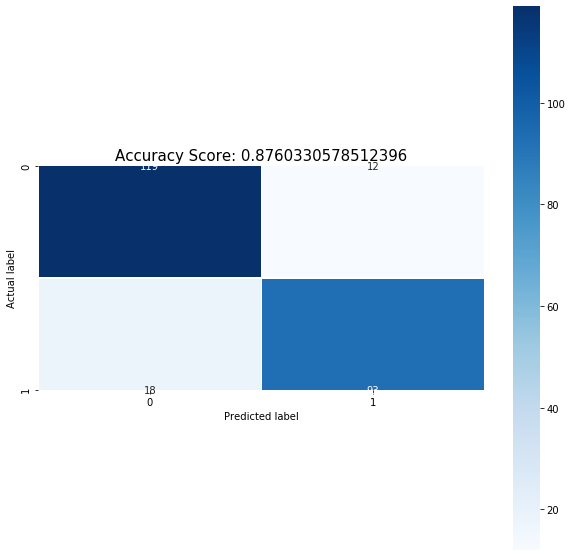

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5,
            square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size=15)
plt.savefig('toy_Digits_ConfusionSeabornCodementor.png')
# plt.show();

## ROC Curves for Model Selection

### Plotting ROC curves

In [106]:
X = X_train

In [109]:
log_reg_vanilla = pipe

steps_l2 = steps.copy()


In [113]:
steps_l2[-1] = ('lr', LogisticRegression(max_iter=10000, penalty='l2', C=.01))
log_reg_l2 = Pipeline(steps_l2)

In [114]:
log_reg_vanilla.fit(X, y_train)

y_probs_vanilla = log_reg_vanilla.predict_proba(X)

In [115]:
log_reg_l2.fit(X, y_train)
y_probs_l2 = log_reg_l2.predict_proba(X)

In [116]:
import matplotlib.pyplot as plt

%matplotlib inline

In [117]:
from sklearn.metrics import roc_curve

In [120]:
y_train = y_train.map({'Yes': 1, 'No': 0})

In [121]:
fpr_v, tpr_v, thresholds_v = roc_curve(y_train, y_probs_vanilla[:,1])
fpr_l2, tpr_l2, thresholds_l2 = roc_curve(y_train, y_probs_l2[:,1])

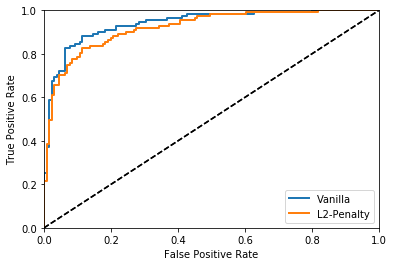

In [122]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


plot_roc_curve(fpr_v, tpr_v, label='Vanilla')
plot_roc_curve(fpr_l2, tpr_l2, label='L2-Penalty')
plt.legend()
plt.show()

Also we can measure the __A__rea __U__nder __C__urve scores


In [123]:
from sklearn.metrics import roc_auc_score

In [126]:
from sklearn.metrics import f1_score

In [124]:

roc_auc_score(y_train, y_probs_vanilla[:,1])

0.9401004057492607

In [125]:
roc_auc_score(y_train, y_probs_l2[:,1])

0.9216697613644179

### The Default Measure (in most prebuilt models) - Accuracy

$$ \frac{(TP + TN)}{(TP + FP + TN + FN)} $$

Category definitions - possible outcomes in binary classification

- TP = True Positive (class 1 correctly classified as class 1) - e.g. Patient with cancer tests positive for cancer
- TN = True Negative (class 0 correctly classified as class 0) - e.g. Patient without cancer tests negative for cancer
- FP = False Positive (class 0 incorrectly classified as class 1) - e.g. Patient without cancer tests positive for cancer
- FN = False Negative (class 1 incorrectly classified as class 0) - e.g. Patient with cancer tests negative for cancer

 $$ \text{Possible misclassifications} $$

<img src='./img/type-1-type-2.jpg' width=400/>
 

Remember that Logistic Regression gives probability predictions for each class, in addition to the final classification. By default, threshold for the prediction is set to 0.5, but we can adjust that threshold.

### The AUC / ROC curve (Area Under Curve of the Receiver Operating Characteristic)

<img src='img/pop-curve.png' width=500/>


### Using Cross Validation Scores for Model Evaluation

In [139]:
from sklearn.model_selection import cross_val_score

In [153]:
cross_val_score(pipe, X, y_train, cv=5, scoring='roc_auc')

array([0.95652174, 0.88047138, 0.88986014, 0.86188811, 0.86538462])

In [154]:
_.mean()

0.8908251973469365

In [155]:
cross_val_score(pipe_l2, X, y_train, cv=5, scoring='roc_auc')

array([0.95819398, 0.88552189, 0.86713287, 0.88811189, 0.91608392])

In [156]:
_.mean()

0.9030089073567333